In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 4.3 MB/s 
     |████████████████████████████████| 287 kB 9.5 MB/s 


In [ ]:
! pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import the packages that needed 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
# from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from rouge import Rouge
import contractions
import re

In [ ]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/cnn_dailymail/train.csv')
# delete the duplicated units in the column of article
df = df.drop(['id'], axis=1)
# only use parts of the training samples
df = df.sample(frac=0.05)
df = df[~df.article.duplicated()]
df.reset_index(drop=True,inplace=True)
df.head(5)

,article,highlights
0,"By . Ryan Gorman . PUBLISHED: . 19:11 EST, 13 ...",John Azabache has taught at the school since 2...
1,By . Paul Bentley and Wills Robinson . PUBLISH...,Dylan Alkins was playing on the Newhaven seafr...
2,One journalist bore the full brunt of former r...,John Hopoate was in court for his son Jamil's ...
3,"By . Jill Reilly . PUBLISHED: . 06:57 EST, 12 ...",Lama al-Ghamdi's back was broken and she had b...
4,A man who claims to suffer from an extremely r...,"Man uploads picture to Reddit forum, attractin..."


In [ ]:
def clean_text(text,remove_stopwords=True):
    # the pipeline to clean the text
    # expand the contractions
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
    return text

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in df.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('-----------Cleaning Summaries Complete-----------')

# clean the text and remove the stopwords
clean_texts = []
for text in df.article:
    clean_texts.append(clean_text(text))
print('-----------Cleaning Texts Complete-----------')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


-----------Cleaning Summaries Complete-----------
-----------Cleaning Texts Complete-----------


In [ ]:
data = {
    'text':clean_texts,
    'highlight':clean_summaries
}
clean_df = pd.DataFrame(data=data)
clean_df.loc[:,'text_length'] = clean_df['text'].apply(lambda x:len(x.split()))
clean_df.loc[:,'highlight_length'] = clean_df['highlight'].apply(lambda x:len(x.split()))

[(0.0, 200.0)]

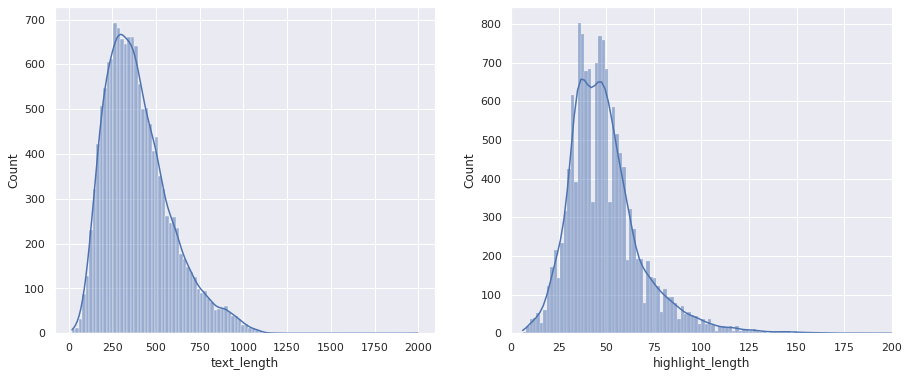

In [ ]:
# visualize the word_length of both the text and the highlight
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
fig,ax = plt.subplots(nrows=1,ncols=2,squeeze=True,figsize=(15,6))
sns.histplot(x='text_length',data=clean_df,ax=ax[0],kde=True)
sns.histplot(x='highlight_length',data=clean_df,ax=ax[1],kde=True).set(xlim=(0,200))

In [ ]:
max_text_len=800
max_summary_len=80

In [ ]:
clean_df = clean_df.where((clean_df['text_length'] < max_text_len) & (clean_df['highlight_length'] < max_summary_len)).reset_index(drop=True)
clean_df.highlight = clean_df.highlight.apply(lambda x : 'sostok '+ str(x) + ' eostok')
clean_df.dropna(how='any',inplace=True)
clean_df.head()

,text,highlight,text_length,highlight_length
0,ryan gorman published 19 11 est 13 july 2013 u...,sostok john azabache has taught at the school ...,232.0,38.0
1,paul bentley wills robinson published 12 34 es...,sostok dylan alkins was playing on the newhave...,376.0,45.0
2,one journalist bore full brunt former rugby le...,sostok john hopoate was in court for his son j...,307.0,60.0
3,jill reilly published 06 57 est 12 february 20...,sostok lama al ghamdi s back was broken and sh...,408.0,59.0
4,man claims suffer extremely rare medical condi...,sostok man uploads picture to reddit forum at...,293.0,53.0


In [ ]:
# split the data into train and validation group
train_x, val_x, train_y, val_y = train_test_split(clean_df['text'], clean_df['highlight'], test_size=0.1, random_state=123)


In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))
thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value

    if value < thresh:
        count += 1
        frequency += value
# use the common words, substract rare words from the total vocabulary 
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)
print("% of rare words in vocabulary:", (count/total_count) * 100)

Text Vocab:  45914
% of rare words in vocabulary: 58.0510177977561


In [ ]:
# reassign a tokenizer
maxlen_text = 800
maxlen_sum = 80

t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')

In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value
s_max_features = total_count-count
print('Text Vocab: ', s_max_features)
print("% of rare words in vocabulary:", (count/total_count) * 100)

Text Vocab:  8470
% of rare words in vocabulary: 76.711575474292


In [ ]:
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
train_y = pad_sequences(train_y, maxlen=maxlen_sum, padding='post')

In [ ]:
# validation dataset
val_x = t_tokenizer.texts_to_sequences(val_x)
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

val_y = s_tokenizer.texts_to_sequences(val_y)
val_y = pad_sequences(val_y, maxlen=maxlen_sum, padding='post')

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# pretrained embedding from gloves
embedding_index = {}
# first use 100 dimension to test the word embedding result
dim = 100
with open('drive/My Drive/Colab Notebooks/glove.6B/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
# encodder embedding
t_embed = np.zeros((t_max_features, dim))
for word, i in t_tokenizer.word_index.items():
    vec = embedding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

# decoder embedding
s_embed = np.zeros((s_max_features, dim))
for word, i in s_tokenizer.word_index.items():
    vec = embedding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 128
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(t_max_features, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output1)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(s_max_features, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
# attn_out, attn_states = tf.keras.layers.Attention()([encoder_outputs, decoder_outputs])
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(s_max_features+1, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 100)     4591400     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 800, 128),   117248      ['embedding[0][0]']              
                                 (None, 128),                                                 

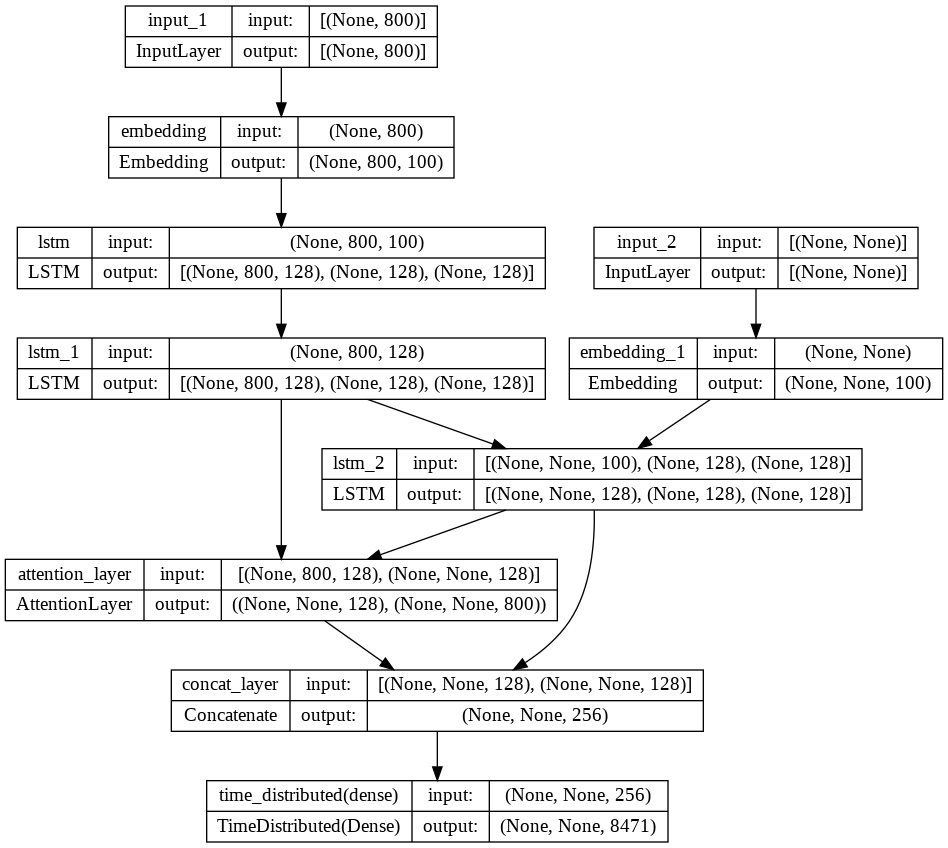

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    to_file='drive/My Drive/Colab Notebooks/seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, 
          validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/10
91/91 - 4767s - loss: 4.1995 - val_loss: 3.6791 - 4767s/epoch - 52s/step
Epoch 2/10
91/91 - 4776s - loss: 3.6929 - val_loss: 3.5179 - 4776s/epoch - 52s/step
Epoch 3/10


In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.show()

In [ ]:
reverse_target_word_index=s_tokenizer.index_word
reverse_source_word_index=t_tokenizer.index_word
target_word_index=s_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = tf.keras.Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = tf.keras.Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
import csv
hyps = []
with open('drive/My Drive/Colab Notebooks/attention.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(50):
        our_summ = decode_sequence(train_x[i].reshape(1,max_text_len))
        hyps.append(our_summ)
        
        writer.writerow([seq2text(train_x[i]), seq2summary(train_y[i]), decode_sequence(train_x[i].reshape(1,max_text_len))])

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, seq2summary(train_y[i]), avg=True, ignore_empty=True)